<a href="https://colab.research.google.com/github/Xiongfeng-Jin/GAN-In-Action/blob/master/Semi_supervised_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras import  backend as K
from keras.datasets import mnist
from keras.layers import  Dense, Flatten, Reshape, Activation, BatchNormalization, Dropout, Input, Concatenate, Lambda
from keras.layers.advanced_activations import  LeakyReLU
from keras.utils import  to_categorical
from keras.models import  Sequential, Model
from keras.optimizers import  Adam
from keras.layers.convolutional import  Conv2D, Conv2DTranspose

Using TensorFlow backend.


In [0]:
image_rows = 28
image_cols = 28
channels = 1
image_shape = (image_rows,image_cols,channels)
z_dim = 100
num_classes = 10

In [0]:
class Dataset:
  def __init__(self,num_labeled):
    self.num_labeled = num_labeled
    (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()

    def preprocess_imgs(x):
      x = (x.astype(np.float32) - 127.5) / 127.5
      x = np.expand_dims(x,axis=3)
      return x

    def preprocess_labels(y):
      return y.reshape(-1,1)

    self.x_train = preprocess_imgs(self.x_train)
    self.y_train = preprocess_labels(self.y_train)
    self.x_test = preprocess_imgs(self.x_test)
    self.y_test = preprocess_labels(self.y_test)

  def batch_labeled(self,batch_size):
    idx = np.random.randint(0,self.num_labeled,batch_size)
    imgs = self.x_train[idx]
    labels = self.y_train[idx]
    return imgs, labels

  def batch_unlabeled(self,batch_size):
    idx = np.random.randint(self.num_labeled,self.x_train.shape[0],batch_size)
    imgs = self.x_train[idx]
    return imgs

  def training_set(self):
    x_train = self.x_train[range(self.num_labeled)]
    y_train = self.y_train[range(self.num_labeled)]
    return x_train, y_train
  
  def test_set(self):
    return self.x_test, self.y_test



In [4]:
num_labeled = 100
dataset = Dataset(num_labeled)

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
def build_generator(z_dim):
  model = Sequential()
  model.add(Dense(256*7*7,input_dim=z_dim))
  model.add(Reshape((7,7,256)))
  model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2DTranspose(64,kernel_size=3,strides=1,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2DTranspose(1,kernel_size=3,strides=2,padding='same'))
  model.add(Activation('tanh'))
  return model

In [0]:
def build_discriminator_net(image_shape):
  model = Sequential()
  model.add(Conv2D(32,kernel_size=3,strides=2,input_shape=image_shape,padding='same'))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2D(64,kernel_size=3,strides=2,input_shape=image_shape,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2D(128,kernel_size=3,strides=2,input_shape=image_shape,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(num_classes))
  return model

In [0]:
def build_discriminator_supervised(discriminator_net):
  model = Sequential()
  model.add(discriminator_net)
  model.add(Activation('softmax'))
  return model

In [0]:
def build_discriminator_unsupervised(discriminator_net):
  model = Sequential()
  model.add(discriminator_net)
  def predict(x):
    prediction = 1.0 - (1.0/(K.sum(K.exp(x),axis=-1,keepdims=True) + 1))
    return prediction

  model.add(Lambda(predict))
  return model

In [0]:
def build_gan(generator,discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

In [10]:
discriminator_net = build_discriminator_net(image_shape)
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=Adam())
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',optimizer=Adam())
generator = build_generator(z_dim)
discriminator_unsupervised.trainable = False
gan = build_gan(generator,discriminator_unsupervised)
gan.compile(loss='binary_crossentropy',optimizer=Adam())












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
supervised_losses = []
iteration_checkpoints = []
iterations = 8000
batch_size = 32
sample_interval = 800

In [0]:
def train(interations, batch_size, sample_interval):
  real = np.ones((batch_size,1))
  fake = np.zeros((batch_size,1))
  for iteration in range(interations):
    imgs, labels = dataset.batch_labeled(batch_size)
    labels = to_categorical(labels,num_classes=num_classes)
    imgs_unlabeled = dataset.batch_unlabeled(batch_size)
    z = np.random.normal(0,1,(batch_size,z_dim))
    gen_imgs = generator.predict(z)
    d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs,labels)
    d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled,real)
    d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs,fake)
    d_loss_unsupervised = 0.5*np.add(d_loss_real,d_loss_fake)
    z = np.random.normal(0,1,(batch_size,z_dim))
    gen_imgs = generator.predict(z)
    g_loss = gan.train_on_batch(z,np.ones((batch_size,1)))

    if (iteration + 1) % sample_interval == 0:
      supervised_losses.append(d_loss_supervised)
      iteration_checkpoints.append(iteration + 1)
      print("%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]" % (iteration + 1, d_loss_supervised, 100 * accuracy, d_loss_unsupervised, g_loss))

In [13]:
train(iterations, batch_size, sample_interval)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


800 [D loss supervised: 0.0007, acc.: 100.00%] [D loss unsupervised: 0.3313] [G loss: 3.318324]
1600 [D loss supervised: 0.0016, acc.: 100.00%] [D loss unsupervised: 0.1637] [G loss: 5.748621]
2400 [D loss supervised: 0.0004, acc.: 100.00%] [D loss unsupervised: 0.3265] [G loss: 2.815048]
3200 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.1276] [G loss: 6.211654]
4000 [D loss supervised: 0.0002, acc.: 100.00%] [D loss unsupervised: 0.1206] [G loss: 7.882980]
4800 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.2086] [G loss: 4.512885]
5600 [D loss supervised: 0.0005, acc.: 100.00%] [D loss unsupervised: 0.0964] [G loss: 4.592863]
6400 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.1358] [G loss: 5.158007]
7200 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.5086] [G loss: 2.312468]
8000 [D loss supervised: 0.0006, acc.: 100.00%] [D loss unsupervised: 0.4385] [G loss: 3.665719]


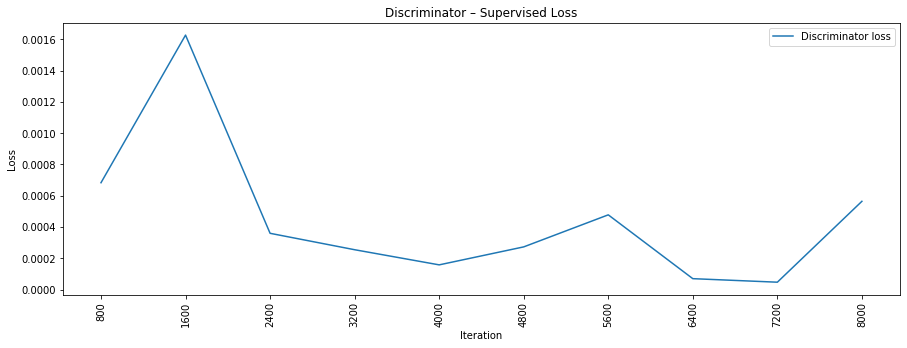

In [15]:
losses = np.array(supervised_losses)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [16]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

100/100 [==============================] - 0s 2ms/step
Training Accuracy: 100.00%


In [17]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 1s 64us/step
Test Accuracy: 91.36%


In [0]:
# Fully supervised classifier with the same network architecture as the SGAN Discriminator
mnist_classifier = build_discriminator_supervised(build_discriminator_net(image_shape))
mnist_classifier.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [20]:
imgs, labels = dataset.training_set()

# One-hot encode labels
labels = to_categorical(labels, num_classes=num_classes)

# Train the classifier
training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=30,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['acc']

Epoch 1/30
100/100 [==============================] - 1s 8ms/step - loss: 2.6180 - acc: 0.2200
Epoch 2/30
100/100 [==============================] - 0s 261us/step - loss: 0.9915 - acc: 0.7500
Epoch 3/30
100/100 [==============================] - 0s 256us/step - loss: 0.5309 - acc: 0.8300
Epoch 4/30
100/100 [==============================] - 0s 227us/step - loss: 0.3680 - acc: 0.9000
Epoch 5/30
100/100 [==============================] - 0s 237us/step - loss: 0.2153 - acc: 0.9700
Epoch 6/30
100/100 [==============================] - 0s 236us/step - loss: 0.1541 - acc: 0.9500
Epoch 7/30
100/100 [==============================] - 0s 290us/step - loss: 0.1073 - acc: 0.9900
Epoch 8/30
100/100 [==============================] - 0s 260us/step - loss: 0.1081 - acc: 0.9900
Epoch 9/30
100/100 [==============================] - 0s 256us/step - loss: 0.0629 - acc: 1.0000
Epoch 10/30
100/100 [==============================] - 0s 250us/step - loss: 0.0526 - acc: 0.9900
Epoch 11/30
100/100 [==========

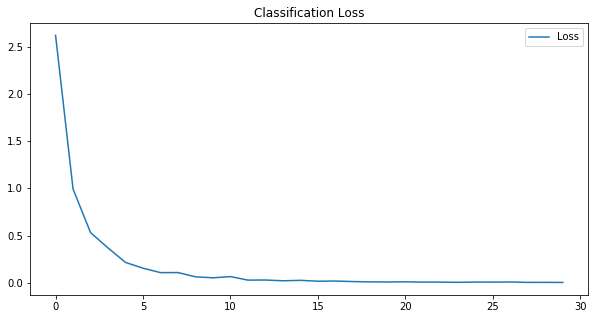

In [21]:
# Plot classification loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()

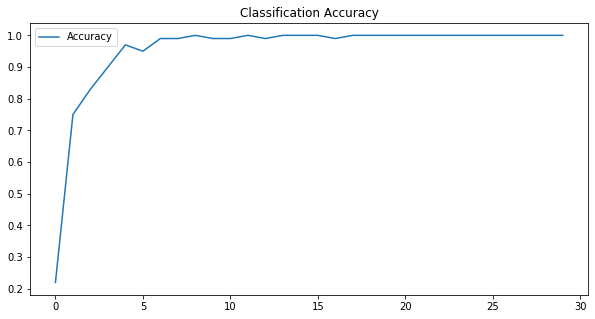

In [22]:
# Plot classification accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()

In [23]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

100/100 [==============================] - 0s 2ms/step
Training Accuracy: 100.00%


In [24]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 1s 67us/step
Test Accuracy: 70.87%
